# Проект № 5 - Компьютер говорит "Нет"

Суть проекта - построить модель банковского скоринга с помощью модели Логистической регрессии

Загружаем библиотеки

In [1]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

from datetime import datetime, timedelta

Загружаем данные

In [2]:
PATH_to_file = '/kaggle/input/sf-dst-scoring/'
train = pd.read_csv(PATH_to_file + 'train.csv')
test = pd.read_csv(PATH_to_file + 'test.csv')
sample_submission = pd.read_csv(PATH_to_file + 'sample_submission.csv')

In [3]:
# Объединяем тренировочные и тестовые данные в один датасет.
train['train'] = 1 # помечаем тренировочные
test['train'] = 0 # помечаем тестовые
data = pd.concat([train, test], ignore_index=True)
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
17022,21419,28JAN2014,UGR,M,54,N,N,0,0,-1.553455,1,40,2,2,20000,1,2,N,0.0,1
21013,70660,18MAR2014,GRD,F,25,N,N,0,0,-2.442509,0,60,1,1,27500,3,2,Y,0.0,1
74059,86263,02APR2014,SCH,M,35,N,N,1,0,-1.624181,2,70,2,3,55000,1,3,N,NaN,0
1936,42275,18FEB2014,GRD,M,65,N,N,0,0,-2.017634,2,60,2,3,45000,1,4,N,0.0,1
35944,29714,05FEB2014,GRD,F,32,Y,Y,0,0,-2.165630,0,50,2,3,50000,1,3,N,0.0,1


In [4]:
# Для контроля зафиксируем размер тренировочного и тестового датасетов.
print('Размер тренировочного датасета: ', train.shape,
      'Размер тестового датасета: ', test.shape, 
      'Размер объединенного датасета: ',
      train.shape[0]+test.shape[0], sep='\n')

Размер тренировочного датасета: 
(73799, 20)
Размер тестового датасета: 
(36349, 19)
Размер объединенного датасета: 
110148


## Описание признаков:
client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Признак 'client_id' - не нужен, т.к. не влияет на оценку вероятности "дефолта" при выдаче кредита. Однако, для представления решения на площадке соревнования Kaggle - нужно сопоставлять данные по client_id - поэтому не убираем столбец 

Проверим число пропущенных значений

In [6]:
data.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
train                   0
dtype: int64

Пропущены значения только в признаке 'education' (не считая значения дефолта на test).
Заполним пропуски по данному значению

In [7]:
data.education = data.education.fillna('None')
data.education.value_counts()

SCH     57998
GRD     34768
UGR     14748
PGR      1865
None      478
ACD       291
Name: education, dtype: int64

Замена на 'None' спорный вариант, т.к. его в 1.5 раза больше, чем реально существующий тип ACD. В процессе проверки работоспособности модели возможно применять различные варианты заполнения пропусков (например, на самый частый, либо все имеющиеся в той же пропорции, как и реально указанные).

In [8]:
data.sample(15)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
102128,85037,01APR2014,GRD,F,27,N,N,0,0,-1.759437,1,60,2,3,28000,1,3,N,NaN,0
42438,95480,11APR2014,GRD,F,37,N,N,0,0,-2.348444,1,60,2,3,20000,1,2,N,0.0,1
11436,14047,21JAN2014,SCH,M,46,Y,N,0,0,-2.468647,6,40,2,3,30000,1,3,N,0.0,1
33566,51840,28FEB2014,PGR,M,27,N,N,1,0,-2.672458,0,80,2,3,10000,1,3,N,0.0,1
90837,28046,04FEB2014,SCH,M,26,N,N,0,0,-1.852779,6,50,1,1,25000,1,3,N,NaN,0
8362,34757,11FEB2014,GRD,F,28,Y,N,0,0,-1.503288,3,40,2,3,30000,1,4,Y,0.0,1
15805,29260,05FEB2014,SCH,M,40,N,N,0,0,-1.968549,9,60,2,3,40000,4,1,N,1.0,1
20013,52958,01MAR2014,SCH,M,41,N,N,0,0,-1.734178,1,60,1,1,30000,1,3,N,0.0,1
16516,83263,31MAR2014,SCH,F,55,N,N,0,0,-2.328625,1,40,1,2,10000,1,3,N,0.0,1
105551,72328,20MAR2014,SCH,F,59,N,N,0,0,-1.871129,1,50,1,2,32000,1,4,N,NaN,0


Теперь разделим все признаки на 4 типа: категориальные, биномиальные, числовые и дата. Таким образом будет удобнее проводить дальнейший анализ и предобработку данных

In [9]:
# Разделяем признаки на 4 типа:

# Бинарные признаки
bin_cols = ['sex','car','car_type','good_work','foreign_passport']

# Категориальные признаки
cat_cols = ['education', 'home_address', 'work_address',
            'region_rating', 'sna', 'first_time']

# Числовые признаки
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt',
            'income', 'score_bki']

# Дата
date_col = ['app_date']

## Работа с числовыми признаками

Визуализируем признаки

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


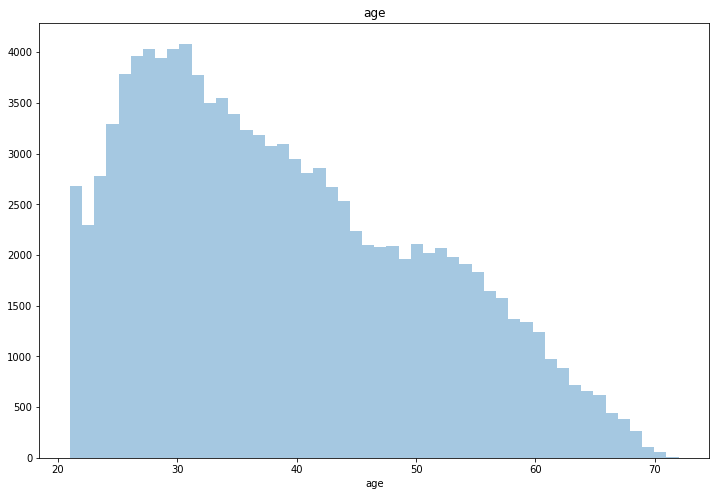

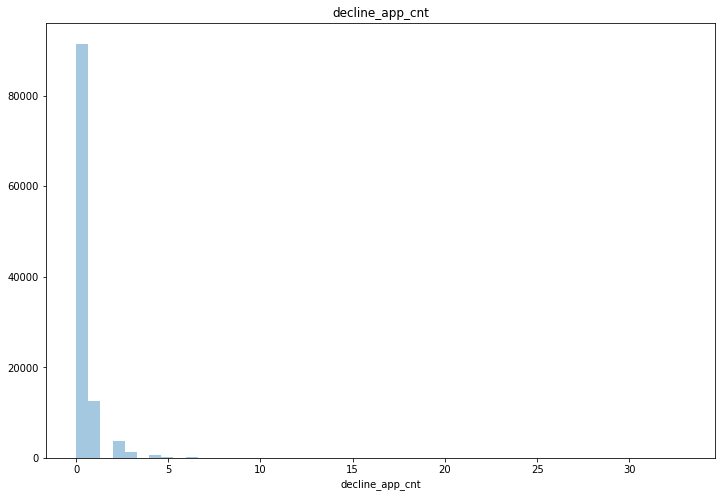

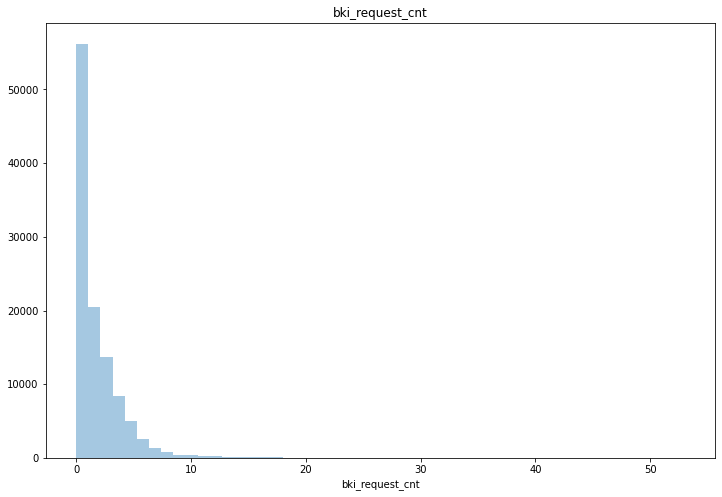

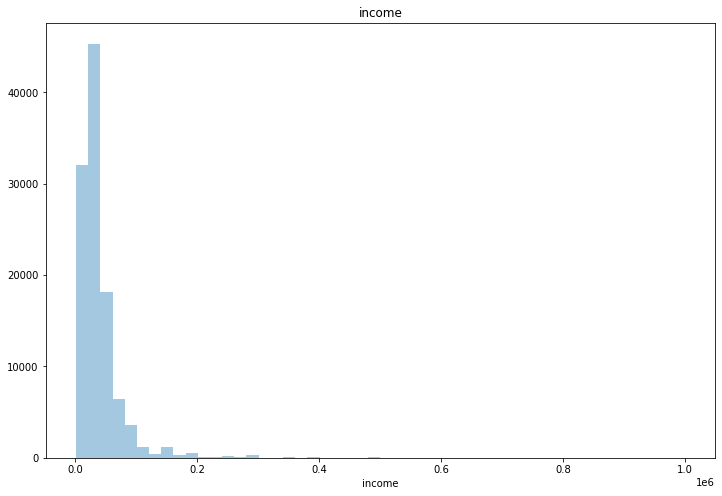

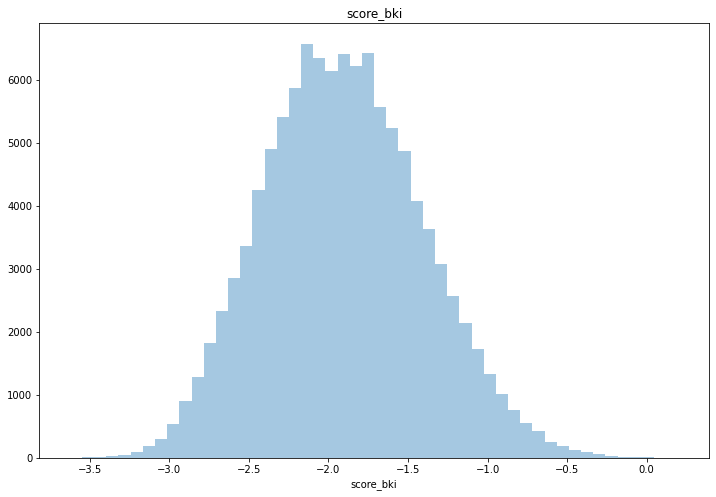

In [10]:
plt.rcParams["figure.figsize"] = (12, 8)
for i in num_cols:
    plt.figure()
    sns.distplot(data[i], kde = False, rug=False)
    plt.title(i)
    plt.show()

Среди указанных гистограмм распределения видно, что у признака 'score_bki' (скоринговый балл по данным из БКИ) распределение очень напоминает нормальное распределение. У признака 'age' (возраст) - распределение имеет хвост справа (т.е. у распреедления смещение влево). У оставшихся 3 признаков - более ярко выраженный хвост справа, и распределение скорее логнормальное. Прологарифмируем признаки (кроме 'score_bki')

In [11]:
log_num_cols = ['age', 'decline_app_cnt',
                'bki_request_cnt', 'income']
data_log = np.log(data[log_num_cols])

In [12]:
data_log.head(3)

,age,decline_app_cnt,bki_request_cnt,income
0,4.127134,-inf,0.000000,9.798127
1,4.077537,-inf,1.098612,9.852194
2,3.218876,0.693147,0.000000,10.308953


После логарифмирования распределение признаков 'age' и 'income' стало больше похоже на нормальное распределение (особенно у признака 'income'). Пока-что не будем применять логарифмирование к модели, потом будем испытывать на резульататх метрики. 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


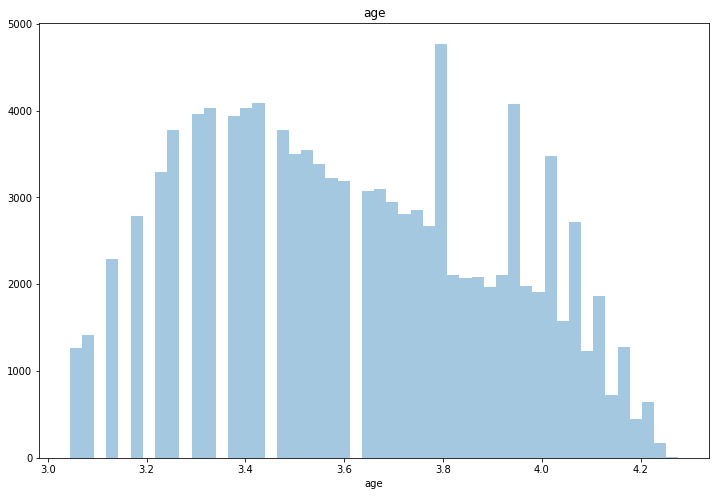

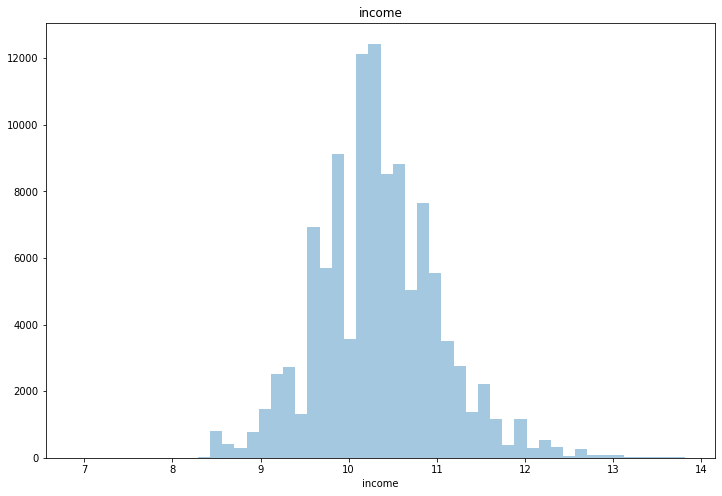

In [13]:
for i in ['age', 'income']:
    plt.figure()
    sns.distplot(data_log[i], kde = False, rug=False)
    plt.title(i)
    plt.show()

С остальными 2 признаками ('decline_app_cnt' и 'bki_request_cnt') сложнее, поскольку логарифмирование выдает значение '-inf'. Поэтому принимаем решение не логарифмировать данные признаки, в случае необходимости повышения качества модели возможно повторно обратиться к этому пункту. 

In [14]:
data_log[['decline_app_cnt', 'bki_request_cnt']].value_counts()

decline_app_cnt  bki_request_cnt
-inf             -inf               25090
                  0.000000          23370
                  0.693147          17048
                  1.098612          11190
                  1.386294           6730
                                    ...  
 1.945910         3.258097              1
                  2.944439              1
                  2.890372              1
                  2.833213              1
 3.496508         0.693147              1
Length: 266, dtype: int64

Построим Boxplot-ы для оценки численных значений у 'дефолтных' и 'не дефолтных' заемщиков

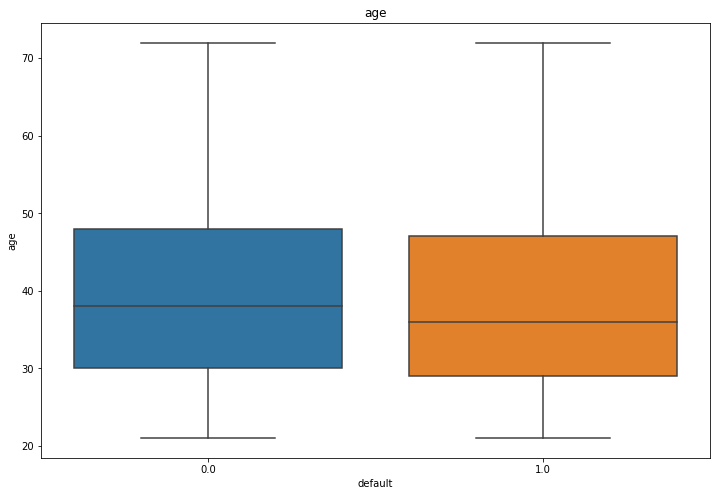

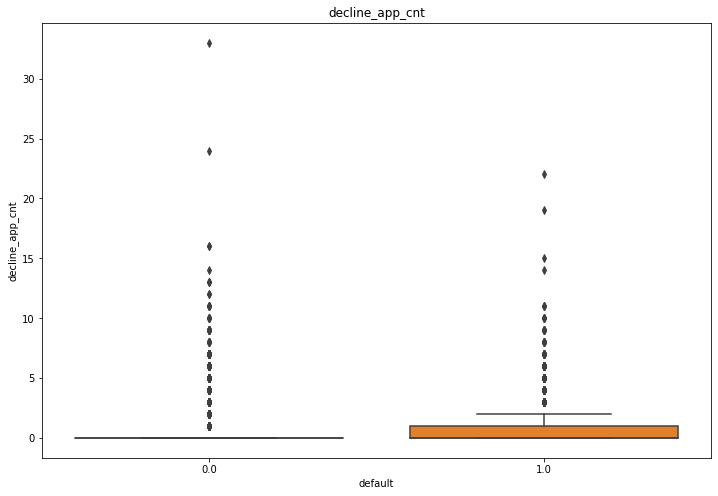

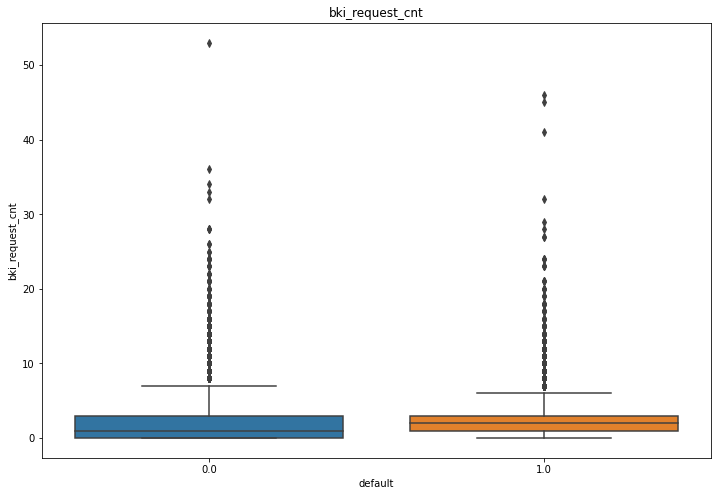

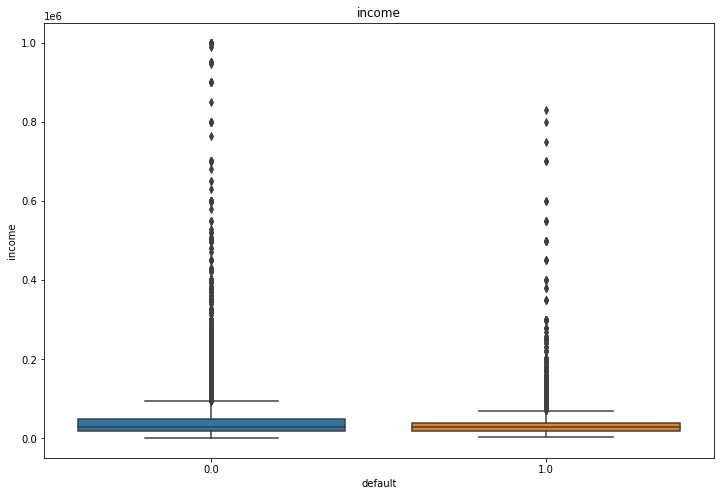

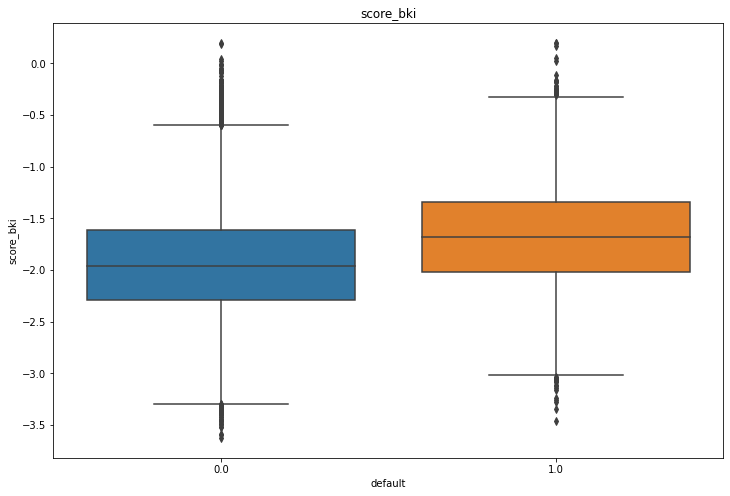

In [15]:
for i in num_cols:
    plt.figure()
    sns.boxplot(x = 'default', y = i, data = data)
    plt.title(i)
    plt.show()

При построении первой модели для предсказания - не будем вычленять возможные выбросы. Как вариант для повышения результата при оценивании метрики.

Корреляция числовых признаков

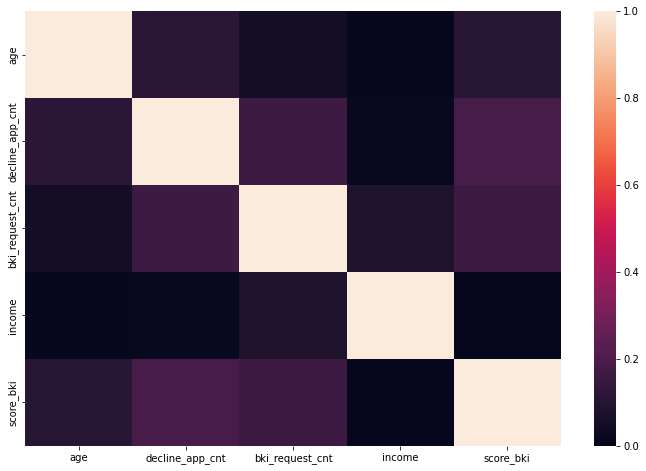

In [16]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1);

In [17]:
data[num_cols].corr().abs()

,age,decline_app_cnt,bki_request_cnt,income,score_bki
age,1.000000,0.111454,0.046975,0.018664,0.104682
decline_app_cnt,0.111454,1.000000,0.159927,0.022241,0.187869
bki_request_cnt,0.046975,0.159927,1.000000,0.080475,0.157451
income,0.018664,0.022241,0.080475,1.000000,0.011721
score_bki,0.104682,0.187869,0.157451,0.011721,1.000000


Из матрицы корреляций видно, что все числовые признаки имеют низкую скоррелированность (максимальное значение 0.187), что положительно влияет для линейных моделей, которым важна низкая корреляция признаков. Отсюда следует вывод о том, что все числовые признаки можно оставлять в модели для предсказания

Оценка значимости числовых признаков

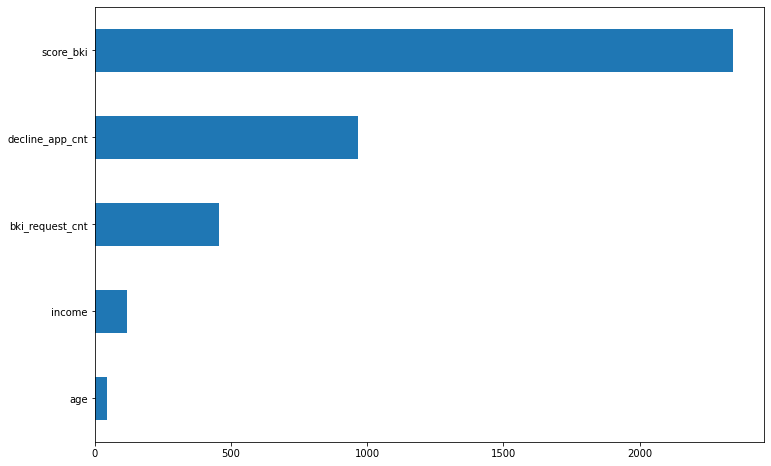

In [18]:
imp_num = pd.Series(f_classif(data.query('train == 1')[num_cols],
                              data.query('train == 1')['default'])[0],
                    index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

###### Среди числовых признаков наиболее значим именно новый признак 'score_bki'

## Работа с бинарными признаками 

In [19]:
# Для бинарных признаков - используем LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
13249,85786,02APR2014,UGR,1,37,0,0,0,0,-1.657457,2,50,2,3,25000,1,4,0,0.0,1
27482,66450,15MAR2014,SCH,0,33,1,0,2,0,-1.526128,5,40,2,3,28000,4,1,0,1.0,1
55005,24513,31JAN2014,UGR,1,30,1,1,0,0,-1.912334,0,50,1,1,25000,1,4,0,0.0,1
2037,90097,06APR2014,GRD,1,32,0,0,0,0,-1.661350,4,70,2,3,90000,1,3,1,0.0,1
58748,95770,12APR2014,GRD,1,50,0,0,0,0,-1.559747,1,80,2,3,70000,1,4,1,1.0,1


## Работа с категориальными признаками 

In [20]:
# Сколько изначально столбцов категориальных признаков
len(cat_cols)

6

В результате категориальные признаки из 6 столбцов преобразуются в 27 столбцов (показано ниже)

## Расчет "наивной" модели

In [21]:
train = data.query('train == 1').drop(['train'], axis=1)
test = data.query('train == 0').drop(['train'], axis=1)

In [22]:
# Вынесем бинарные признаки в X_bin
X_bin = train[bin_cols].values

In [23]:
# Итогово проведем стандартизацию числовых признаков и вынесем в X_num

X_num = StandardScaler().fit_transform(train[num_cols].values)

In [24]:
# Для категориальных признаков - используем OneHotEncoder

X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
X_cat.shape

(73799, 27)

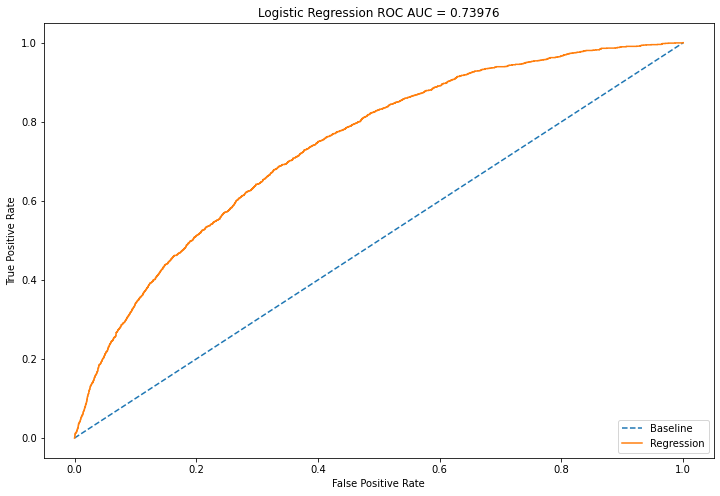

In [25]:
# Объединяем X_tr из разных типов признаков
# и выставляем целевую переменную 'default'

X = np.hstack([X_num, X_bin, X_cat])
y = train['default'].values

# Разделяем train - valid

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42)

# Обучаем 'наивную' модель Логистической регрессии
model_naive = LogisticRegression(solver='liblinear')
model_naive.fit(X_train, y_train)

# Предсказываем значения
y_pred = model_naive.predict(X_test)

# Строим ROC AUC для оценки
probs = model_naive.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

У "наивной" модели результат метрики ROC AUC = 0.73976. Дальнейшие шаги будем проводить для повышения значения данной метрики.

## Регуляризация

Строим с учетом гиперпараметров. Путем ручного подбора определены параметры регуляризации C = 0.018 и тип "l2'.

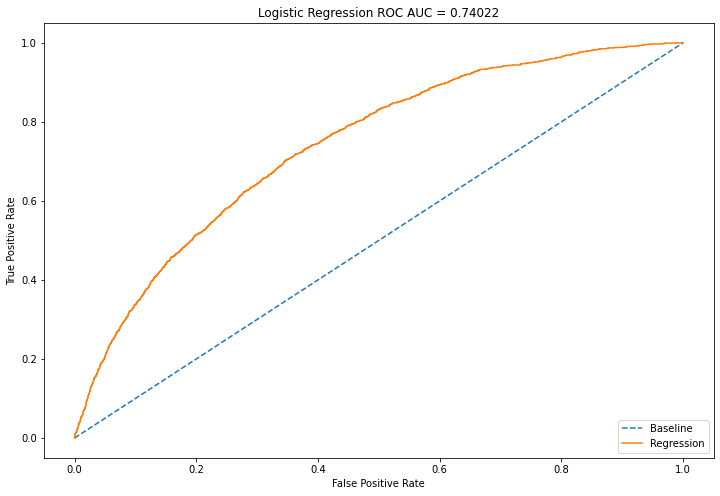

In [26]:
model = LogisticRegression(solver='liblinear',
                           penalty = 'l2',
                           C = 0.018)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

С учетом регуляризации на наивной модели ROC AUC = 0.74022

## Проводим обработку численных признаков 'age', 'income' с помощью логарифмирования

In [27]:
log_num_cols = ['age', 'income']
train[log_num_cols] = np.log(train[log_num_cols])

In [28]:
# Итогово проведем стандартизацию числовых признаков с учетом
# логарифмирования 'age', 'income'и вынесем в X_num

X_num = StandardScaler().fit_transform(train[num_cols].values)

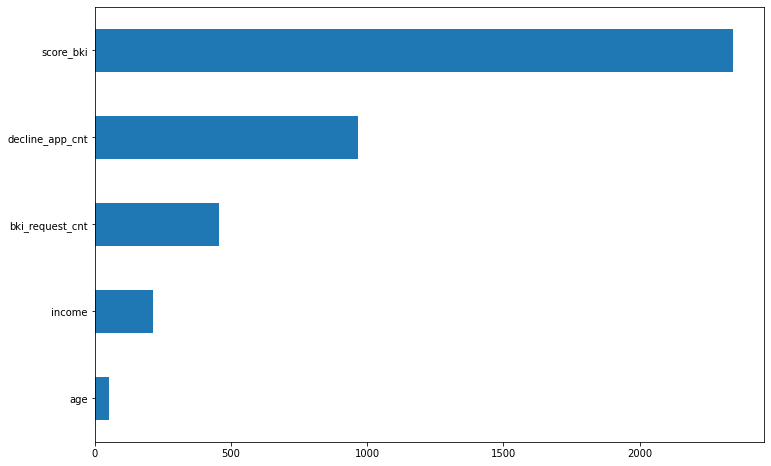

In [29]:
# Оценка вклада признаков
imp_num = pd.Series(f_classif(train[num_cols],
                              train['default'])[0],
                    index = num_cols
                   )
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

Строим модель с учетом логарифмирования 'age', 'income'

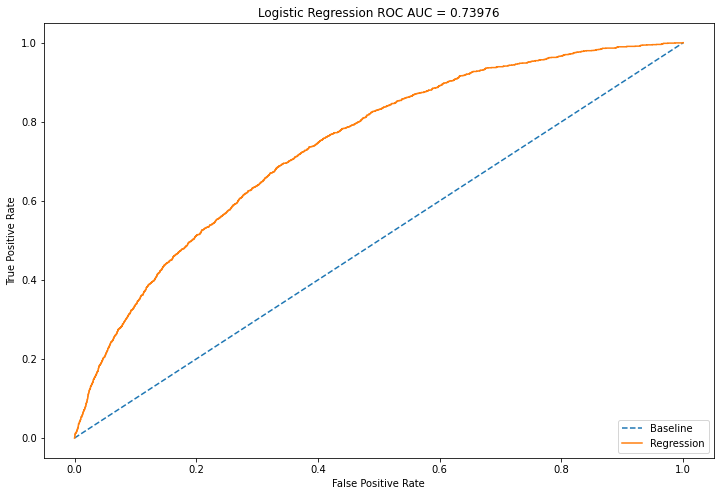

In [30]:
# Объединяем
X_log = np.hstack([X_num, X_bin, X_cat])
y = train['default'].values

# Разделяем train - valid
X_train, X_test, y_train, y_test = train_test_split(
    X_log,
    y,
    test_size=0.20,
    random_state=42)

# Обучаем модель Логистической регрессии 
# с логарифмированием 'age', 'income'
model_log = LogisticRegression(solver='liblinear')
model_log.fit(X_train, y_train)

# Предсказываем значения
y_pred = model_log.predict(X_test)

# Строим ROC AUC для оценки
probs = model_log.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Результат с учетом логарифмирования 'age', 'income' ROC AUC = 0.73976. Значение ровно такое же, как и у "наивной модели" - пользу от логарифмирования нет.

## Работа с датой

In [31]:
for i in range(len(data.app_date)):
        data.app_date[i] = datetime.strptime(
            data.app_date[i], '%d%b%Y')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
data.app_date = pd.to_datetime(data.app_date)

# Добавляем категориальный признак месяц
data['month'] = data.app_date.dt.month

# Добавляем категориальный признак день недели подачи заявки 
data['day'] = data.app_date.dt.day_of_week

# Укажем, сколько дней прошло с момента подачи заявки - числовой
data['time_diff'] = (datetime.now() - data.app_date).dt.days

In [33]:
# Для категориальных признаков 'month' (1,2,3,4) и
# 'day of week' (0,1,2,3,4,5,6) - используем OneHotEncoder
month_dow = ['month', 'day']
X_month_dow = OneHotEncoder(sparse = False).fit_transform(
    data.query('train == 1')[month_dow].values)

In [34]:
# Готовим столбец дней от подачи заявки с учетом стандартиазции
time_diff = ['time_diff']
X_td = StandardScaler().fit_transform(data.query('train == 1')[time_diff].values)

Строим модель с учетом логарифмирования 'age','income' + с добавлением столбца дней от подачи заявки + 'month' + 'day of week' + Регуляризацией l-2

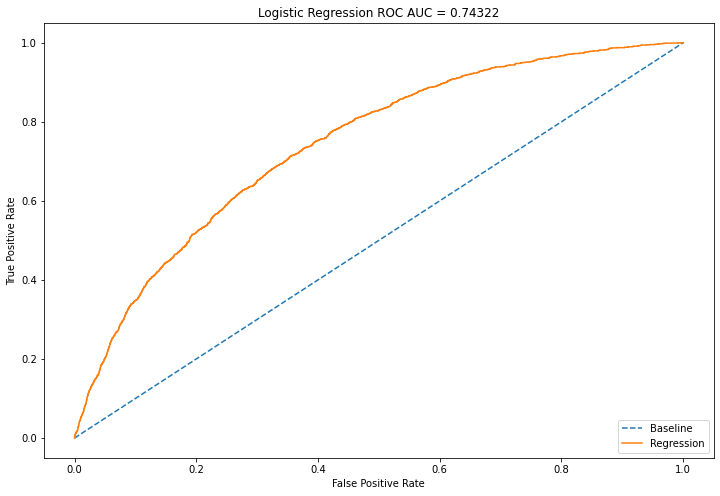

In [35]:
# Объединяем
X_log_td_month_dow = np.hstack(
    [X_num, X_bin, X_cat, X_td, X_month_dow])
y = train['default'].values

# Разделяем train - valid
X_train, X_test, y_train, y_test = train_test_split(
    X_log_td_month_dow,
    y,
    test_size=0.20,
    random_state=42
    )

# Обучаем модель Логистической регрессии с логарифмированием 'age',
# 'income' + с добавлением столбца дней от подачи заявки + 'month'
# + 'day of week' + Регуляризацией l-2
model_log_td_month_dow = LogisticRegression(
    solver='liblinear',
    penalty = 'l2',
    C = 0.018
    )
model_log_td_month_dow.fit(X_train, y_train)

# Предсказываем значения
y_pred = model_log_td_month_dow.predict(X_test)

# Строим ROC AUC для оценки
probs = model_log_td_month_dow.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Результат ROC AUC = 0.74322

array([[12872,    61],
       [ 1793,    34]])

<AxesSubplot:>

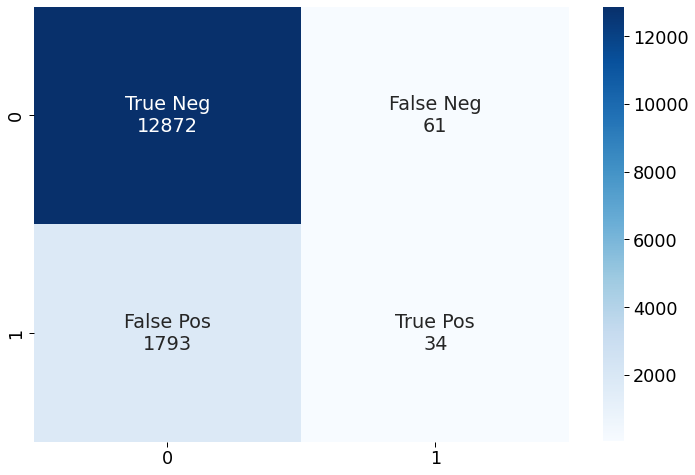

In [36]:
# Confusion matrix:

CM = confusion_matrix(y_test, y_pred)
display(CM)

sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Neg', 'False Pos', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=labels, fmt='', cmap='Blues')

In [37]:
# Другие метрики
print('accuracy_score: {}'.format(np.round(
    accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(
    f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(
    recall_score(y_test, y_pred), 4)))

accuracy_score: 0.8744
f1_score: 0.0354
recall_score: 0.0186


Вывод о модели: модель хорошо предсказывает недефолтного клиента, однако пропускает много дефолтных клиентов.

## Часть для непосредственно соревнования

In [38]:
X_cat_test = OneHotEncoder(sparse = False).fit_transform(
    test[cat_cols].values)
X_num_test = StandardScaler().fit_transform(test[num_cols].values)
X_bin_test = test[bin_cols].values
X_td_test = StandardScaler().fit_transform(
    data.query('train == 0')[time_diff].values)
X_month_dow_test = OneHotEncoder(sparse = False).fit_transform(
    data.query('train == 0')[month_dow].values)

X_test2 = np.hstack([X_num_test,
                     X_bin_test,
                     X_cat_test,
                     X_td_test,
                     X_month_dow_test])

y_probs = model_log_td_month_dow.predict_proba(X_test2)[:,1]

test['default'] = y_probs
submission = test[['client_id','default']]
display(submission.sample(10))
display(submission.shape)

submission.to_csv('submission.csv', index=False)

,client_id,default
99750,28279,0.025035
75065,18642,0.109452
89046,47713,0.036411
77067,108429,0.051603
105411,108609,0.028714
88223,81626,0.352035
103068,102153,0.026637
108002,20976,0.136614
77246,102746,0.032637
101464,39145,0.055350


(36349, 2)